In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lsst.geom as geom
import lsst.daf.butler as dafButler

from astropy.table import Table
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.source.injection.inject_exposure import ExposureInjectTask

logger = logging.getLogger("lsst")
logger.setLevel(logging.ERROR)

# -----------------------
# User-configurable params
# -----------------------
REPO = "/repo/main"
COLLECTIONS = "LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530"
WHERE="instrument='LSSTComCam' AND skymap='lsst_cells_v1' AND day_obs>=20241101 AND day_obs<=20241127 AND exposure.observation_type='science' AND band in ('u','g','r','i','z','y') AND (exposure not in (2024110600163, 2024112400111, 2024110800318, 2024111200185, 2024111400039, 2024111500225, 2024111500226, 2024111500239, 2024111500240, 2024111500242, 2024111500288, 2024111500289, 2024111800077, 2024111800078, 2024112300230, 2024112400094, 2024112400225, 2024112600327))"

N_DETECTORS = 4
N_INJECT = 200
MAG_SPAN = 1.0          # inject uniform in [m5_stack - MAG_SPAN, m5_stack + MAG_SPAN]
SNR_FOR_M5 = 5.0

# Detection / matching
MAX_SEP_TIGHT_ARCSEC = 0.6
MAX_SEP_LOOSE_ARCSEC = 1.5
DETECTED_RADIUS_PIX = 5

RNG_SEED = 12345


In [2]:
butler = dafButler.Butler(REPO, collections=COLLECTIONS)

refs = list(set(
    butler.registry.queryDatasets(
        "preliminary_visit_image",
        instrument="LSSTComCam",
        where=WHERE,
        findFirst=True,
    )
))
refs = sorted(refs, key=lambda r: (int(r.dataId["visit"]), int(r.dataId["detector"])))
refs = refs[:N_DETECTORS]

print("N refs:", len(refs))
print("First:", refs[0].dataId)


N refs: 4
First: {instrument: 'LSSTComCam', detector: 0, visit: 2024110800245, band: 'i', day_obs: 20241108, physical_filter: 'i_06'}


In [3]:
def estimate_m5_local_from_psf_var(calexp, x, y, snr=5.0):
    """
    Local m5 at (x,y) using:
      alpha = sum(phi^2)
      sigma_f = sqrt(sum(phi^2 * V)) / alpha
      f_snr = snr * sigma_f
      m_snr = instFluxToMagnitude(f_snr)
    """
    bbox = calexp.getBBox()
    point = geom.Point2D(float(x), float(y))

    psf = calexp.getPsf()
    phi_img = psf.computeKernelImage(point)
    phi = phi_img.array.astype(np.float64)

    var_full = calexp.getMaskedImage().getVariance()
    phi_bbox = phi_img.getBBox()
    phi_bbox_clipped = phi_bbox.clippedTo(bbox)
    V = var_full[phi_bbox_clipped].array.astype(np.float64)

    if phi_bbox_clipped != phi_bbox:
        dx0 = phi_bbox_clipped.getMinX() - phi_bbox.getMinX()
        dy0 = phi_bbox_clipped.getMinY() - phi_bbox.getMinY()
        dx1 = dx0 + phi_bbox_clipped.getWidth()
        dy1 = dy0 + phi_bbox_clipped.getHeight()
        phi = phi[dy0:dy1, dx0:dx1]

    phi2 = phi * phi
    alpha = float(np.sum(phi2))
    if not np.isfinite(alpha) or alpha <= 0:
        return np.nan

    sigma_f = float(np.sqrt(np.sum(phi2 * V)) / alpha)
    f_snr = snr * sigma_f
    return float(calexp.getPhotoCalib().instFluxToMagnitude(f_snr))


def characterize_calibrate(exposure, doApCorr=True, doDeblend=True):
    char_config = CharacterizeImageTask.ConfigClass()
    char_config.doApCorr = bool(doApCorr)
    char_config.doDeblend = bool(doDeblend)
    char_task = CharacterizeImageTask(config=char_config)
    char_res = char_task.run(exposure)

    calib_config = CalibrateTask.ConfigClass()
    calib_config.doAstrometry = False
    calib_config.doPhotoCal = False
    calib_task = CalibrateTask(config=calib_config, icSourceSchema=char_res.sourceCat.schema)
    calib_res = calib_task.run(exposure, background=char_res.background, icSourceCat=char_res.sourceCat)
    return calib_res.outputExposure, calib_res.sourceCat


def get_detected_mask(exposure):
    m = exposure.getMask()
    if "DETECTED" not in m.getMaskPlaneDict():
        return None
    bit = m.getPlaneBitMask("DETECTED")
    return (m.array & bit) != 0


# FIX: ensure colon is present; your PDF had it missing
def build_pointsource_injection_table(calexp, mags, xys, source_type="Star"):
    wcs = calexp.getWcs()
    tab = Table(
        names=("ra", "dec", "source_type", "mag", "x", "y"),
        dtype=("float64", "float64", "str", "float64", "float64", "float64"),
    )
    for m, (x, y) in zip(mags, xys):
        sp = wcs.pixelToSky(x, y)
        tab.add_row((sp.getRa().asDegrees(), sp.getDec().asDegrees(),
                     source_type, float(m), float(x), float(y)))
    return tab


def nearest_source_match_idx(post_src, ra_deg, dec_deg, max_sep_arcsec):
    """Return (matched, idx, sep_arcsec) using nearest neighbor on-sky."""
    if post_src is None or len(post_src) == 0:
        return False, None, np.inf

    ra0 = np.deg2rad(ra_deg)
    dec0 = np.deg2rad(dec_deg)

    best_i = None
    best_sep2 = np.inf

    for i in range(len(post_src)):
        ra = float(post_src[i].get("coord_ra"))
        dec = float(post_src[i].get("coord_dec"))
        s = np.sin(0.5*(dec-dec0))**2 + np.cos(dec0)*np.cos(dec)*np.sin(0.5*(ra-ra0))**2
        sep = 2.0*np.arcsin(np.sqrt(s))
        if sep*sep < best_sep2:
            best_sep2 = sep*sep
            best_i = i

    sep_arcsec = np.rad2deg(np.sqrt(best_sep2)) * 3600.0
    if sep_arcsec > max_sep_arcsec:
        return False, None, sep_arcsec
    return True, best_i, sep_arcsec


def det_mask_hit_radius(det_mask, x, y, r_pix):
    if det_mask is None:
        return False
    xi = int(round(x)); yi = int(round(y))
    rr = int(r_pix)
    y0 = max(0, yi-rr); y1 = min(det_mask.shape[0]-1, yi+rr)
    x0 = max(0, xi-rr); x1 = min(det_mask.shape[1]-1, xi+rr)
    return bool(det_mask[y0:y1+1, x0:x1+1].any())


In [4]:
def forced_matched_filter_flux_on_arrays(phi, I, V):
    good = np.isfinite(I) & np.isfinite(V) & (V > 0) & np.isfinite(phi)
    if not np.any(good):
        return np.nan, np.nan
    w = 1.0 / V[good]
    num = float(np.sum(phi[good] * I[good] * w))
    den = float(np.sum((phi[good] ** 2) * w))
    if not np.isfinite(den) or den <= 0:
        return np.nan, np.nan
    return num / den, float(np.sqrt(1.0 / den))


def forced_flux_on_diff(calexp_pre, calexp_inj, x, y):
    """
    Forced matched-filter flux on difference image:
      I = inj - pre
      V = pre variance (diagnostic-level approximation)
    """
    bbox = calexp_pre.getBBox()
    point = geom.Point2D(float(x), float(y))

    psf = calexp_pre.getPsf()
    phi_img = psf.computeKernelImage(point)
    phi = phi_img.array.astype(np.float64)

    phi_bbox = phi_img.getBBox()
    phi_bbox_clipped = phi_bbox.clippedTo(bbox)

    I_pre = calexp_pre.getMaskedImage().getImage()[phi_bbox_clipped].array.astype(np.float64)
    I_inj = calexp_inj.getMaskedImage().getImage()[phi_bbox_clipped].array.astype(np.float64)
    I = I_inj - I_pre

    V = calexp_pre.getMaskedImage().getVariance()[phi_bbox_clipped].array.astype(np.float64)

    if phi_bbox_clipped != phi_bbox:
        dx0 = phi_bbox_clipped.getMinX() - phi_bbox.getMinX()
        dy0 = phi_bbox_clipped.getMinY() - phi_bbox.getMinY()
        dx1 = dx0 + phi_bbox_clipped.getWidth()
        dy1 = dy0 + phi_bbox_clipped.getHeight()
        phi = phi[dy0:dy1, dx0:dx1]

    return forced_matched_filter_flux_on_arrays(phi, I, V)

def forced_flux_on_exposure(calexp, x, y):
    bbox = calexp.getBBox()
    point = geom.Point2D(float(x), float(y))

    psf = calexp.getPsf()
    # Try computeImage first (often matches instFlux normalization better than computeKernelImage)
    phi_img = psf.computeImage(point)
    phi = phi_img.array.astype(np.float64)

    phi_bbox = phi_img.getBBox()
    phi_bbox_clipped = phi_bbox.clippedTo(bbox)

    I = calexp.getMaskedImage().getImage()[phi_bbox_clipped].array.astype(np.float64)
    V = calexp.getMaskedImage().getVariance()[phi_bbox_clipped].array.astype(np.float64)

    if phi_bbox_clipped != phi_bbox:
        dx0 = phi_bbox_clipped.getMinX() - phi_bbox.getMinX()
        dy0 = phi_bbox_clipped.getMinY() - phi_bbox.getMinY()
        dx1 = dx0 + phi_bbox_clipped.getWidth()
        dy1 = dy0 + phi_bbox_clipped.getHeight()
        phi = phi[dy0:dy1, dx0:dx1]

    return forced_matched_filter_flux_on_arrays(phi, I, V)



In [5]:
def run_detector_dataid(
    dataId,
    n_inject=N_INJECT,
    mag_span=MAG_SPAN,
    snr_for_m5=SNR_FOR_M5,
    rng_seed=RNG_SEED,
    doApCorr=True,
    doDeblend=True,
    place_mode="random",
    max_sep_arcsec_tight=MAX_SEP_TIGHT_ARCSEC,
    max_sep_arcsec_loose=MAX_SEP_LOOSE_ARCSEC,
    det_radius_pix=DETECTED_RADIUS_PIX,
    repo=REPO,
    collections=COLLECTIONS,
):
    rng_local = np.random.default_rng(int(rng_seed))

    # Recreate butler inside worker-safe function (also useful for multiprocessing)
    b = dafButler.Butler(repo, collections=collections)
    calexp_pre = b.get("preliminary_visit_image", dataId=dataId)

    # IMPORTANT: preserve pristine copy for differencing
    try:
        calexp_pre0 = calexp_pre.clone()
    except Exception:
        # fallback if clone() not available in your build
        calexp_pre0 = calexp_pre.Factory(calexp_pre, deep=True)

    m5_stack = float(calexp_pre.info.getSummaryStats().magLim)
    mags = rng_local.uniform(m5_stack - mag_span, m5_stack + mag_span, size=int(n_inject))

    bb = calexp_pre.getBBox()
    margin = 40
    if place_mode == "center":
        x0 = 0.5*(bb.getMinX()+bb.getMaxX())
        y0 = 0.5*(bb.getMinY()+bb.getMaxY())
        jitter = 200.0
        xys = [(rng_local.uniform(x0-jitter, x0+jitter),
                rng_local.uniform(y0-jitter, y0+jitter))
               for _ in range(int(n_inject))]

    else:
        xys = [(rng_local.uniform(bb.getMinX()+margin, bb.getMaxX()-margin),
                rng_local.uniform(bb.getMinY()+margin, bb.getMaxY()-margin))
               for _ in range(int(n_inject))]

    inj_tab = build_pointsource_injection_table(calexp_pre, mags, xys, source_type="Star")

    inj_task = ExposureInjectTask()
    inj_res = inj_task.run(
    [inj_tab],
    calexp_pre,
    calexp_pre.getPsf(),
    calexp_pre.getPhotoCalib(),
    calexp_pre.getWcs(),)
    calexp_inj = inj_res.output_exposure

    calexp_post, post_src = characterize_calibrate(calexp_inj, doApCorr=doApCorr, doDeblend=doDeblend)
    det_mask = get_detected_mask(calexp_post)
    photo_post = calexp_post.getPhotoCalib()

    rows = []
    for inj_id, r in enumerate(inj_tab):
        x = float(r["x"]); y = float(r["y"])
        ra = float(r["ra"]); dec = float(r["dec"])
        mag_inj = float(r["mag"])

        m5_local = estimate_m5_local_from_psf_var(calexp_pre, x, y, snr=snr_for_m5)

        det_hit = det_mask_hit_radius(det_mask, x, y, det_radius_pix)

        m_t, idx_t, sep_t = nearest_source_match_idx(post_src, ra, dec, max_sep_arcsec_tight)
        m_l, idx_l, sep_l = nearest_source_match_idx(post_src, ra, dec, max_sep_arcsec_loose)

        idx = idx_t if m_t else idx_l
        sep_arcsec = float(sep_t if m_t else sep_l)

        if idx is not None:
            f = float(post_src[idx].get("base_PsfFlux_instFlux"))
            fe = float(post_src[idx].get("base_PsfFlux_instFluxErr"))
            stack_mag = float(photo_post.instFluxToMagnitude(f)) if np.isfinite(f) and f > 0 else np.nan
            stack_snr = f/fe if np.isfinite(f) and np.isfinite(fe) and fe > 0 else np.nan
        else:
            f = np.nan; fe = np.nan; stack_mag = np.nan; stack_snr = np.nan

        # --- Pixel-space sanity: does diff image have signal at the injection location?
        xi = int(round(x)); yi = int(round(y))
        img_pre = calexp_pre0.image.array
        img_inj = calexp_inj.image.array
        diff = img_inj - img_pre

        r = 3
        cut = diff[max(0, yi-r):yi+r+1, max(0, xi-r):xi+r+1]
        rows[-1] if False else None  # no-op to keep style
        local_max = float(np.nanmax(cut)) if cut.size else np.nan
        local_sum = float(np.nansum(cut)) if cut.size else np.nan


        # Forced flux on the difference image
        #Fd, sigFd = forced_flux_on_diff(calexp_pre0, calexp_inj, x, y)
        Fd, sigFd = forced_flux_on_exposure(calexp_inj, x, y)


        # IMPORTANT: magnitude undefined for Fd<=0; keep mag as NaN but store flux
        forced_diff_mag = float(photo_post.instFluxToMagnitude(Fd)) if np.isfinite(Fd) and Fd > 0 else np.nan

        F_expected = float(calexp_pre.getPhotoCalib().magnitudeToInstFlux(mag_inj))
        

        rows.append({
            "visit": int(dataId["visit"]),
            "detector": int(dataId["detector"]),
            "inj_id": inj_id,

            "x": x, "y": y,
            "ra": ra, "dec": dec,
            "mag": mag_inj,

            "m5_stack": m5_stack,
            "m5_local": m5_local,

            "det_mask_hit": bool(det_hit),

            "posmatch_0p6": bool(m_t),
            "posmatch_1p5": bool(m_l),
            "sep_arcsec": sep_arcsec,

            "stack_flux": f,
            "stack_fluxerr": fe,
            "stack_mag": stack_mag,
            "stack_snr": stack_snr,

            "forced_diff_flux": Fd,
            "forced_diff_sigmaF": sigFd,
            "forced_diff_mag": forced_diff_mag,
            "F_expected": F_expected,
            "Fd_ratio": (Fd / F_expected) if np.isfinite(Fd) and np.isfinite(F_expected) and F_expected > 0 else np.nan,
            "diff_local_max": local_max,
            "diff_local_sum": local_sum,

        })

    return pd.DataFrame(rows)


In [6]:
from concurrent.futures import ProcessPoolExecutor, as_completed

dataIds = [ref.dataId for ref in refs]

dfs = []
with ProcessPoolExecutor(max_workers=4) as ex:
    futs = []
    for dataId in dataIds:
        seed = RNG_SEED + 100000*int(dataId["visit"]) + int(dataId["detector"])
        futs.append(ex.submit(
            run_detector_dataid,
            dataId,
            rng_seed=seed,
            doApCorr=True,
            doDeblend=True,
            place_mode="random",
        ))

    for fut in as_completed(futs):
        dfs.append(fut.result())

inj = pd.concat(dfs, ignore_index=True)
print("inj columns:", sorted(inj.columns))
inj.head()


inj columns: ['F_expected', 'Fd_ratio', 'dec', 'det_mask_hit', 'detector', 'diff_local_max', 'diff_local_sum', 'forced_diff_flux', 'forced_diff_mag', 'forced_diff_sigmaF', 'inj_id', 'm5_local', 'm5_stack', 'mag', 'posmatch_0p6', 'posmatch_1p5', 'ra', 'sep_arcsec', 'stack_flux', 'stack_fluxerr', 'stack_mag', 'stack_snr', 'visit', 'x', 'y']


,visit,detector,inj_id,x,y,ra,dec,mag,m5_stack,m5_local,...,stack_fluxerr,stack_mag,stack_snr,forced_diff_flux,forced_diff_sigmaF,forced_diff_mag,F_expected,Fd_ratio,diff_local_max,diff_local_sum
0,2024110800245,3,0,1695.638232,3037.839652,53.323869,-28.273770,23.954451,24.171849,23.446378,...,307.381869,23.758179,5.547399,1638.417228,312.500988,23.801537,1423.176716,1.151239,63.388611,1096.771851
1,2024110800245,3,1,3244.938902,593.250972,53.195146,-28.159512,24.265177,24.171849,23.518870,...,NaN,NaN,NaN,1369.360235,293.901649,23.996304,1068.977666,1.281000,44.184643,781.286743
2,2024110800245,3,2,3354.866874,3380.941978,53.368191,-28.187976,24.969674,24.171849,23.504367,...,NaN,NaN,NaN,805.209224,294.961238,24.572826,558.688403,1.441249,29.023184,473.740051
3,2024110800245,3,3,47.821659,1135.555192,53.183526,-28.339672,24.948137,24.171849,23.417539,...,NaN,NaN,NaN,1375.157539,315.239315,23.991717,569.881451,2.413059,28.989258,391.777252
4,2024110800245,3,4,537.704746,1933.853472,53.239615,-28.322969,24.721572,24.171849,23.418269,...,NaN,NaN,NaN,521.982475,313.459314,25.043458,702.118875,0.743439,33.369678,479.359619


In [7]:
# Convert injected mag -> expected instFlux using the POST photocalib convention
# (Using the first row's photoCalib is acceptable for diagnostics; for strictness,
# you can re-run per-row using calexp_post, but this is fine for now.)
#
# We'll approximate by converting with the mag->flux relation on each row using:
#   flux = 10**(-0.4*(mag - zp)) ; photoCalib doesn't expose zp directly here,
# so instead we compare using forced_diff_mag where defined and flux otherwise.

good_flux = np.isfinite(inj["forced_diff_flux"].values) & np.isfinite(inj["forced_diff_sigmaF"].values)
print("Fraction finite forced_diff_flux:", float(np.mean(good_flux)))

# For SNR-like diagnostic: Fd / sigma
snr_fd = inj["forced_diff_flux"].values / inj["forced_diff_sigmaF"].values
snr_fd = snr_fd[np.isfinite(snr_fd)]
print("Median forced-diff SNR:", float(np.median(snr_fd)))
print("Frac forced-diff SNR > 0:", float(np.mean(snr_fd > 0)))


Fraction finite forced_diff_flux: 1.0
Median forced-diff SNR: 4.187482692082906
Frac forced-diff SNR > 0: 0.98375


In [8]:
good_mag = np.isfinite(inj["forced_diff_mag"].values)
dmag = (inj.loc[good_mag, "mag"] - inj.loc[good_mag, "forced_diff_mag"]).values
print("Median(m_inj - m_forced_diff_mag) [Fd>0 only]:", float(np.median(dmag)))
print("Std   (m_inj - m_forced_diff_mag) [Fd>0 only]:", float(np.std(dmag)))


Median(m_inj - m_forced_diff_mag) [Fd>0 only]: 0.013206519462855226
Std   (m_inj - m_forced_diff_mag) [Fd>0 only]: 0.6763167735711112


In [9]:
a = inj["det_mask_hit"].astype(bool).values
b0 = inj["posmatch_0p6"].astype(bool).values
b1 = inj["posmatch_1p5"].astype(bool).values

print("det_mask_hit:", float(np.mean(a)))
print("posmatch_0p6:", float(np.mean(b0)))
print("posmatch_1p5:", float(np.mean(b1)))
print("DETECTED & !posmatch_0p6:", float(np.mean(a & ~b0)))
print("DETECTED & !posmatch_1p5:", float(np.mean(a & ~b1)))


det_mask_hit: 0.44625
posmatch_0p6: 0.3625
posmatch_1p5: 0.3875
DETECTED & !posmatch_0p6: 0.08375
DETECTED & !posmatch_1p5: 0.06


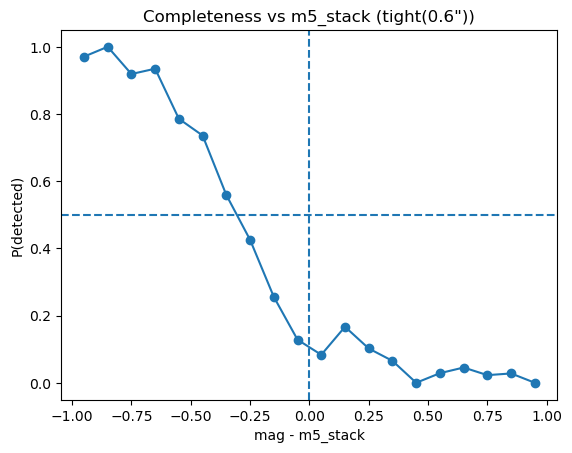

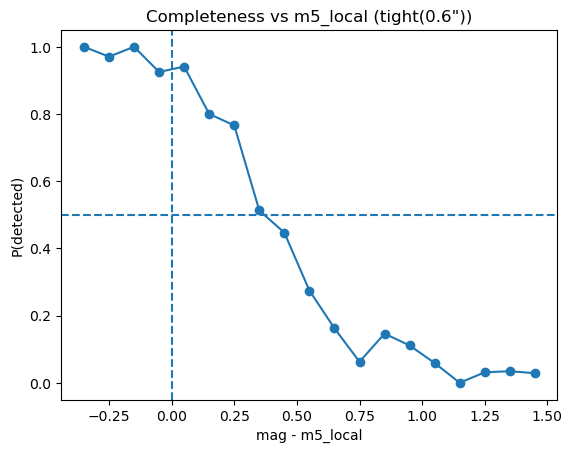

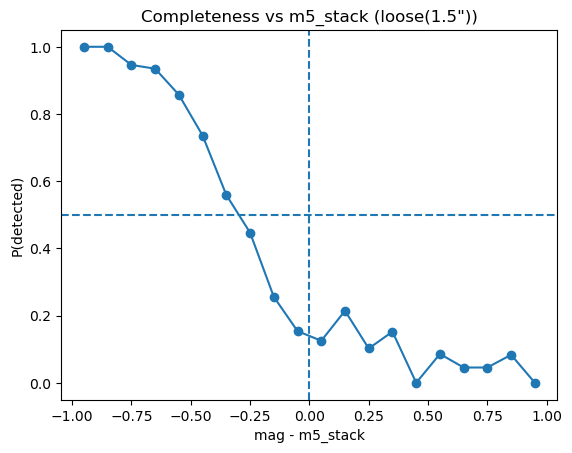

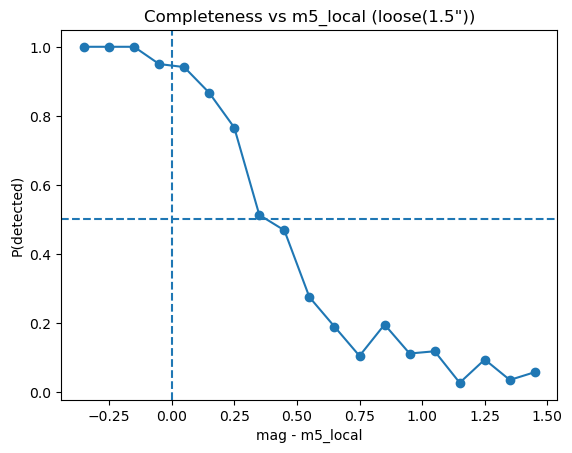

In [10]:
def binned_completeness(x, detected, bins):
    out = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        sel = (x >= lo) & (x < hi)
        n = int(sel.sum())
        if n == 0:
            continue
        out.append({"xmid": 0.5*(lo+hi), "n": n, "p_det": float(np.mean(detected[sel]))})
    return pd.DataFrame(out)

bins_x = np.arange(-1.5, 1.51, 0.1)

x_stack = (inj["mag"] - inj["m5_stack"]).values
x_local = (inj["mag"] - inj["m5_local"]).values

det_tight = inj["posmatch_0p6"].astype(bool).values
det_loose = inj["posmatch_1p5"].astype(bool).values

for name, detv in [("tight(0.6\")", det_tight), ("loose(1.5\")", det_loose)]:
    comp_stack = binned_completeness(x_stack, detv, bins_x)
    comp_local = binned_completeness(x_local, detv, bins_x)

    plt.figure()
    plt.plot(comp_stack["xmid"], comp_stack["p_det"], marker="o")
    plt.axvline(0, linestyle="--"); plt.axhline(0.5, linestyle="--")
    plt.xlabel("mag - m5_stack"); plt.ylabel("P(detected)")
    plt.title(f"Completeness vs m5_stack ({name})")
    plt.show()

    plt.figure()
    plt.plot(comp_local["xmid"], comp_local["p_det"], marker="o")
    plt.axvline(0, linestyle="--"); plt.axhline(0.5, linestyle="--")
    plt.xlabel("mag - m5_local"); plt.ylabel("P(detected)")
    plt.title(f"Completeness vs m5_local ({name})")
    plt.show()


m5_stack - m5_local: median = 0.6969731525462617 std = 0.033130519776047904 N = 800


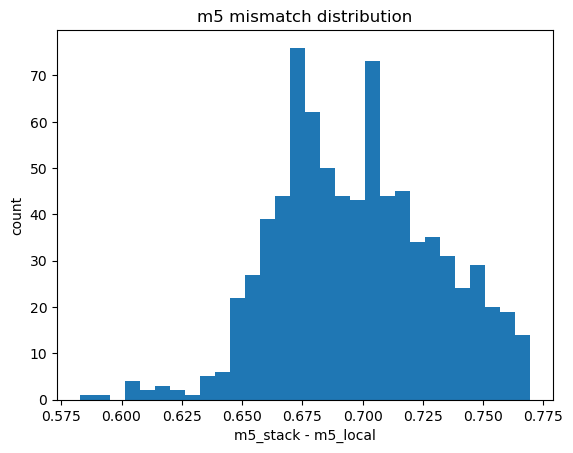

In [11]:
dm5 = (inj["m5_stack"] - inj["m5_local"]).values
dm5 = dm5[np.isfinite(dm5)]
print("m5_stack - m5_local: median =", float(np.median(dm5)), "std =", float(np.std(dm5)), "N =", int(dm5.size))

plt.figure()
plt.hist(dm5, bins=30)
plt.xlabel("m5_stack - m5_local")
plt.ylabel("count")
plt.title("m5 mismatch distribution")
plt.show()


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def binned_completeness(x, detected, bins):
    out = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        sel = (x >= lo) & (x < hi)
        n = int(sel.sum())
        if n == 0:
            continue
        out.append({"xmid": 0.5*(lo+hi), "n": n, "p_det": float(np.mean(detected[sel]))})
    return pd.DataFrame(out)

def plot_completeness_vs_m5(df, det_col, title_suffix=""):
    bins_x = np.arange(-1.5, 1.51, 0.1)
    detv = df[det_col].astype(bool).values

    x_stack = (df["mag"].values - df["m5_stack"].values)
    x_local = (df["mag"].values - df["m5_local"].values)

    comp_stack = binned_completeness(x_stack, detv, bins_x)
    comp_local = binned_completeness(x_local, detv, bins_x)

    plt.figure()
    plt.plot(comp_stack["xmid"], comp_stack["p_det"], marker="o")
    plt.axvline(0, linestyle="--"); plt.axhline(0.5, linestyle="--")
    plt.xlabel(f"mag - m5_stack"); plt.ylabel(f"P(detected)")
    plt.title(f"Completeness vs m5_stack | det={det_col} {title_suffix}")
    plt.show()

    plt.figure()
    plt.plot(comp_local["xmid"], comp_local["p_det"], marker="o")
    plt.axvline(0, linestyle="--"); plt.axhline(0.5, linestyle="--")
    plt.xlabel(f"mag - m5_local"); plt.ylabel(f"P(detected)")
    plt.title(f"Completeness vs m5_local | det={det_col} {title_suffix}")
    plt.show()

def summarize_detection(df, label=""):
    a = df["det_mask_hit"].astype(bool).values
    b0 = df["posmatch_0p6"].astype(bool).values
    b1 = df["posmatch_1p5"].astype(bool).values

    dm5 = (df["m5_stack"] - df["m5_local"]).values
    dm5 = dm5[np.isfinite(dm5)]

    print(label)
    print("  N rows:", len(df))
    print("  det_mask_hit:", float(np.mean(a)))
    print("  posmatch_0p6:", float(np.mean(b0)))
    print("  posmatch_1p5:", float(np.mean(b1)))
    print("  DETECTED & !posmatch_0p6:", float(np.mean(a & ~b0)))
    print("  DETECTED & !posmatch_1p5:", float(np.mean(a & ~b1)))
    print("  m5_stack - m5_local: median", float(np.median(dm5)), "std", float(np.std(dm5)))
    print()

# sanity for forced diff
def summarize_forced_diff(df, label=""):
    good = np.isfinite(df["forced_diff_flux"].values) & np.isfinite(df["forced_diff_sigmaF"].values)
    snr = df.loc[good, "forced_diff_flux"].values / df.loc[good, "forced_diff_sigmaF"].values
    snr = snr[np.isfinite(snr)]
    print(label)
    print("  frac finite forced_diff_flux:", float(np.mean(good)))
    print("  frac SNR_fd > 0:", float(np.mean(snr > 0)))
    print("  frac SNR_fd > 5:", float(np.mean(snr > 5)))
    print("  median SNR_fd:", float(np.median(snr)) if snr.size else np.nan)
    print()


BASELINE (existing inj)
  N rows: 800
  det_mask_hit: 0.44625
  posmatch_0p6: 0.3625
  posmatch_1p5: 0.3875
  DETECTED & !posmatch_0p6: 0.08375
  DETECTED & !posmatch_1p5: 0.06
  m5_stack - m5_local: median 0.6969731525462617 std 0.033130519776047904



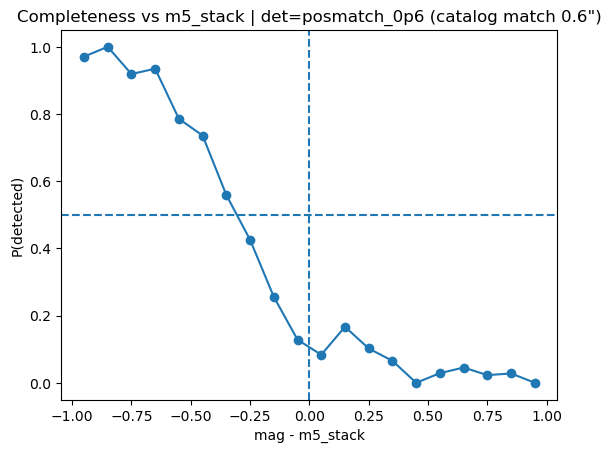

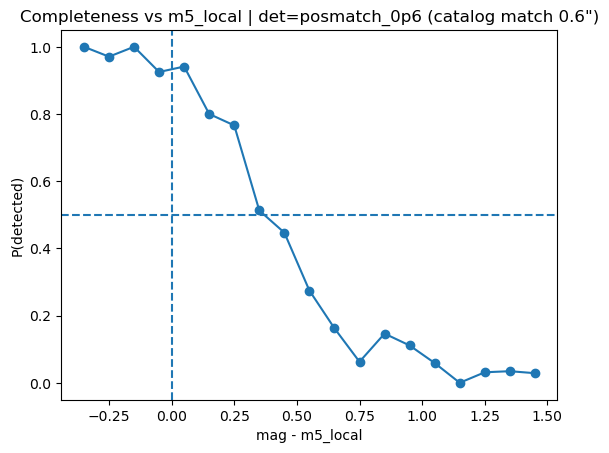

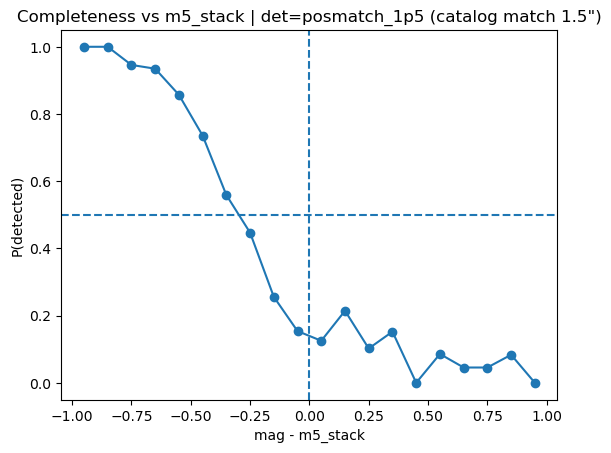

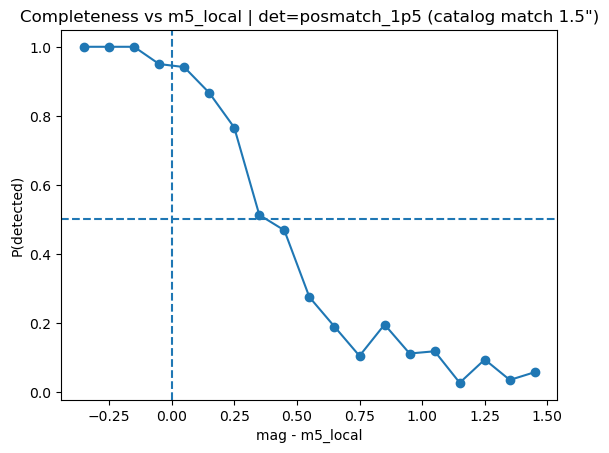

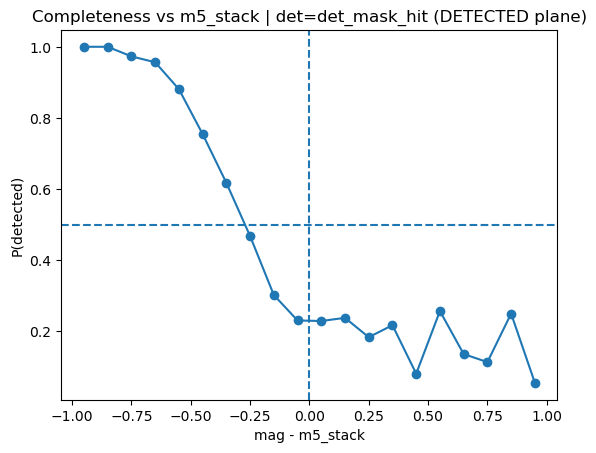

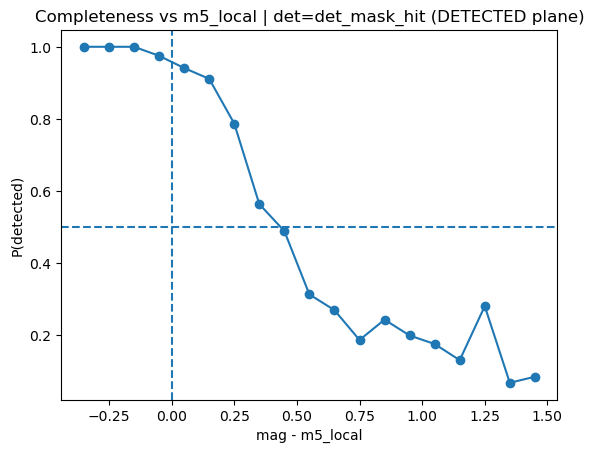

In [13]:
summarize_detection(inj, "BASELINE (existing inj)")

# Compare completeness curves for different "detection definitions"
plot_completeness_vs_m5(inj, det_col="posmatch_0p6", title_suffix="(catalog match 0.6\")")
plot_completeness_vs_m5(inj, det_col="posmatch_1p5", title_suffix="(catalog match 1.5\")")
plot_completeness_vs_m5(inj, det_col="det_mask_hit", title_suffix="(DETECTED plane)")


NO-DEBLEND / NO-APCORR
  N rows: 800
  det_mask_hit: 0.45875
  posmatch_0p6: 0.3575
  posmatch_1p5: 0.38
  DETECTED & !posmatch_0p6: 0.10125
  DETECTED & !posmatch_1p5: 0.07875
  m5_stack - m5_local: median 0.6921789804061973 std 0.034640518984015906

NO-DEBLEND / NO-APCORR (forced diff sanity)
  frac finite forced_diff_flux: 1.0
  frac SNR_fd > 0: 0.98875
  frac SNR_fd > 5: 0.3875
  median SNR_fd: 4.046235674905128



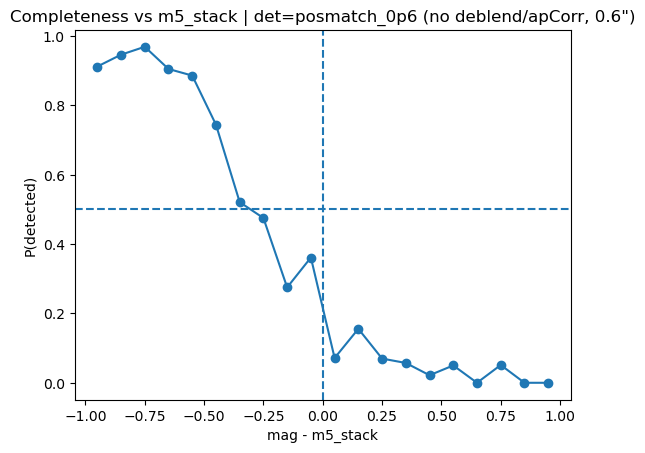

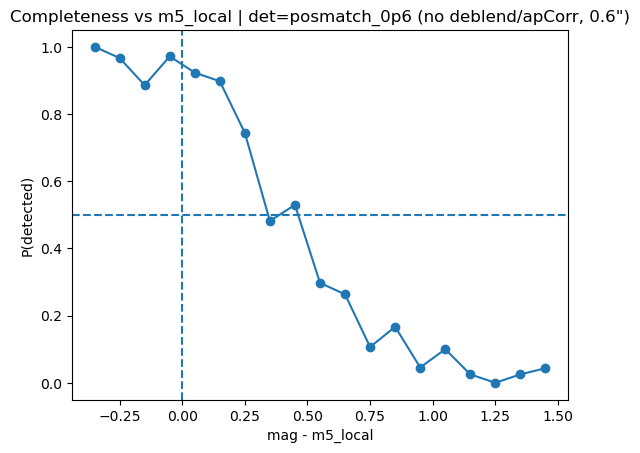

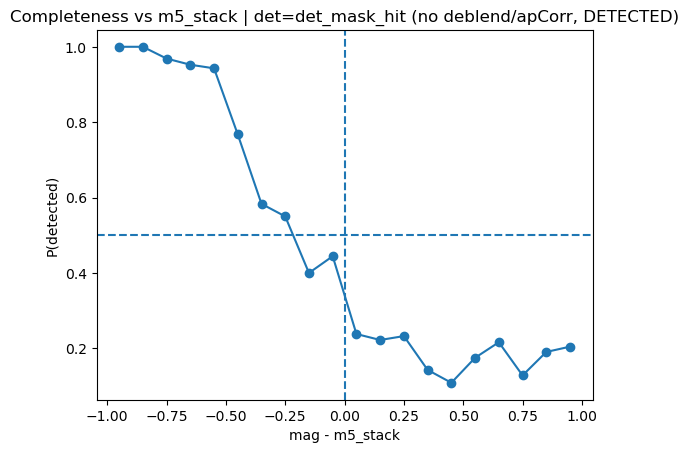

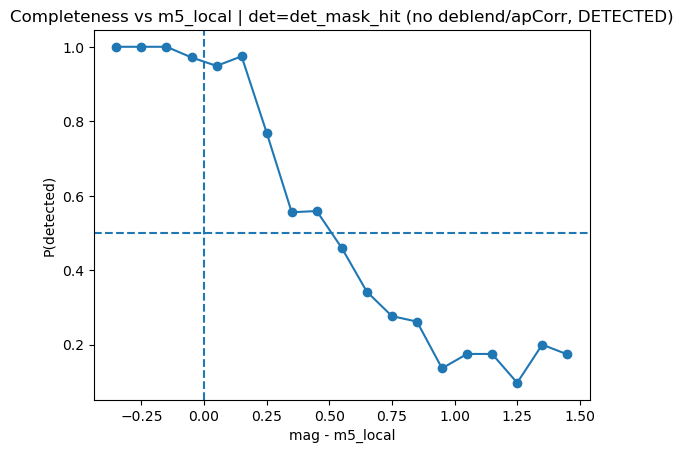

In [14]:
from concurrent.futures import ProcessPoolExecutor, as_completed

def build_inj_parallel(refs, *, doApCorr, doDeblend, place_mode, seed_offset=0, max_workers=4):
    dataIds = [r.dataId for r in refs]
    dfs = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futs = []
        for dataId in dataIds:
            seed = RNG_SEED + seed_offset + 100000*int(dataId["visit"]) + int(dataId["detector"])
            futs.append(ex.submit(
                run_detector_dataid,
                dataId,
                rng_seed=seed,
                doApCorr=doApCorr,
                doDeblend=doDeblend,
                place_mode=place_mode,
            ))
        for fut in as_completed(futs):
            dfs.append(fut.result())
    return pd.concat(dfs, ignore_index=True)

inj_nodb = build_inj_parallel(
    refs,
    doApCorr=False,
    doDeblend=False,
    place_mode="random",
    seed_offset=7,
    max_workers=4,
)

summarize_detection(inj_nodb, "NO-DEBLEND / NO-APCORR")
summarize_forced_diff(inj_nodb, "NO-DEBLEND / NO-APCORR (forced diff sanity)")

plot_completeness_vs_m5(inj_nodb, det_col="posmatch_0p6", title_suffix="(no deblend/apCorr, 0.6\")")
plot_completeness_vs_m5(inj_nodb, det_col="det_mask_hit", title_suffix="(no deblend/apCorr, DETECTED)")


CENTER-ONLY injections
  N rows: 800
  det_mask_hit: 0.595
  posmatch_0p6: 0.4
  posmatch_1p5: 0.47
  DETECTED & !posmatch_0p6: 0.195
  DETECTED & !posmatch_1p5: 0.125
  m5_stack - m5_local: median 0.6988095810366488 std 0.016079945969950115

CENTER-ONLY (forced diff sanity)
  frac finite forced_diff_flux: 1.0
  frac SNR_fd > 0: 0.98375
  frac SNR_fd > 5: 0.43
  median SNR_fd: 4.339173786827201



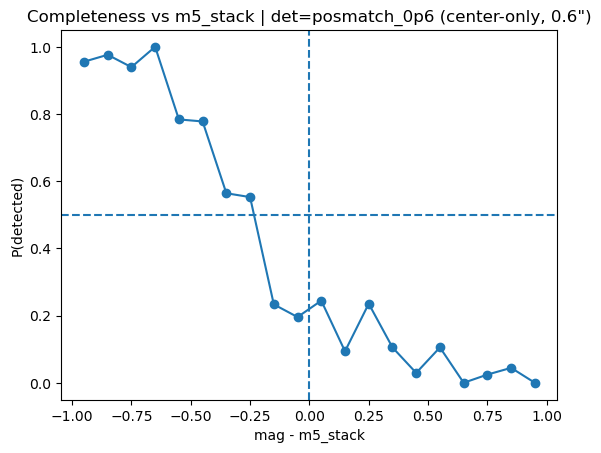

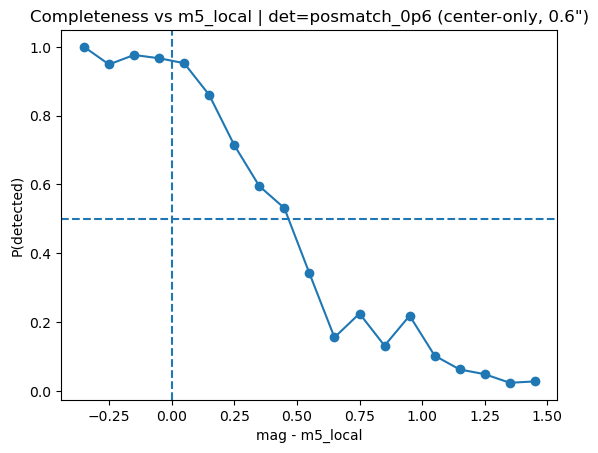

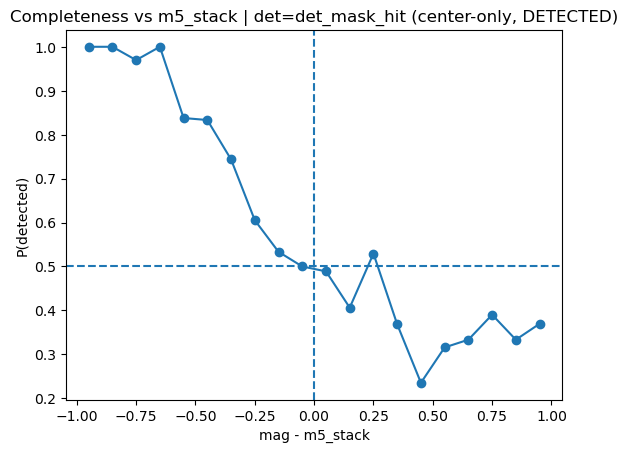

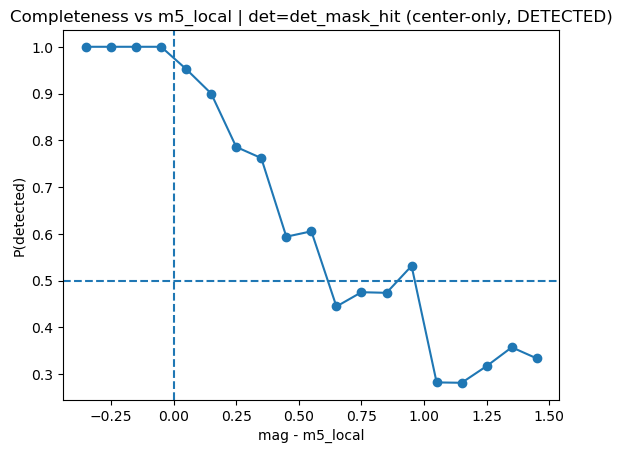

In [15]:
inj_center = build_inj_parallel(
    refs,
    doApCorr=True,
    doDeblend=True,
    place_mode="center",
    seed_offset=13,
    max_workers=4,
)

summarize_detection(inj_center, "CENTER-ONLY injections")
summarize_forced_diff(inj_center, "CENTER-ONLY (forced diff sanity)")

plot_completeness_vs_m5(inj_center, det_col="posmatch_0p6", title_suffix="(center-only, 0.6\")")
plot_completeness_vs_m5(inj_center, det_col="det_mask_hit", title_suffix="(center-only, DETECTED)")


In [16]:
def try_analysis_tools_m5(calexp):
    """
    Best-effort call into analysis_tools limitingMagnitudeMetric.
    Returns float or np.nan if not available.
    """
    try:
        # Common location (may vary by weekly)
        from lsst.analysis.tools.atools.limitingMagnitudeMetric import LimitingMagnitudeMetric
        metric = LimitingMagnitudeMetric()
        # Some versions expect dict-like input; some accept Exposure directly.
        out = metric(calexp)
        # Handle typical return patterns
        if isinstance(out, dict):
            # guess keys
            for k in ("m5", "magLim", "limitingMagnitude", "limMag"):
                if k in out:
                    return float(out[k])
            # if only one value
            if len(out) == 1:
                return float(list(out.values())[0])
        return float(out)
    except Exception:
        return np.nan

# compute per-detector and compare
rows = []
for ref in refs:
    calexp = butler.get("preliminary_visit_image", dataId=ref.dataId)
    m5_stack = float(calexp.info.getSummaryStats().magLim)
    m5_at = try_analysis_tools_m5(calexp)
    rows.append({
        "visit": int(ref.dataId["visit"]),
        "detector": int(ref.dataId["detector"]),
        "m5_stack": m5_stack,
        "m5_analysis_tools": m5_at,
        "dm": (m5_at - m5_stack) if np.isfinite(m5_at) else np.nan
    })

m5cmp = pd.DataFrame(rows)
m5cmp


,visit,detector,m5_stack,m5_analysis_tools,dm
0,2024110800245,0,24.183197,NaN,NaN
1,2024110800245,1,24.227698,NaN,NaN
2,2024110800245,2,24.207778,NaN,NaN
3,2024110800245,3,24.171849,NaN,NaN


=== Baseline ===
baseline
  N rows: 800
  det_mask_hit: 0.44625
  posmatch_0p6: 0.3625
  posmatch_1p5: 0.3875
  DETECTED & !posmatch_0p6: 0.08375
  DETECTED & !posmatch_1p5: 0.06
  m5_stack - m5_local: median 0.6969731525462617 std 0.033130519776047904

=== NoDeblend ===
no deblend/apCorr
  N rows: 800
  det_mask_hit: 0.45875
  posmatch_0p6: 0.3575
  posmatch_1p5: 0.38
  DETECTED & !posmatch_0p6: 0.10125
  DETECTED & !posmatch_1p5: 0.07875
  m5_stack - m5_local: median 0.6921789804061973 std 0.034640518984015906

=== Center-only ===
center-only
  N rows: 800
  det_mask_hit: 0.595
  posmatch_0p6: 0.4
  posmatch_1p5: 0.47
  DETECTED & !posmatch_0p6: 0.195
  DETECTED & !posmatch_1p5: 0.125
  m5_stack - m5_local: median 0.6988095810366488 std 0.016079945969950115



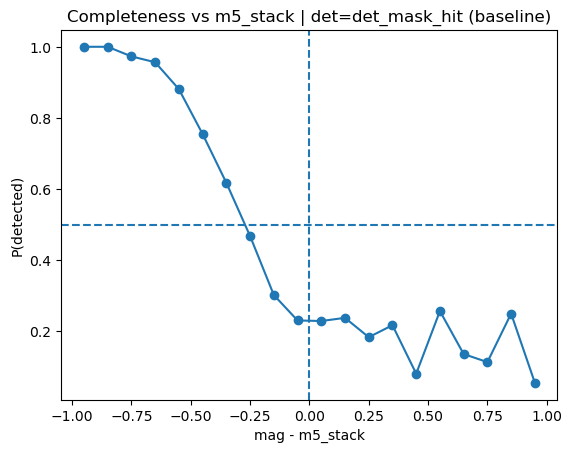

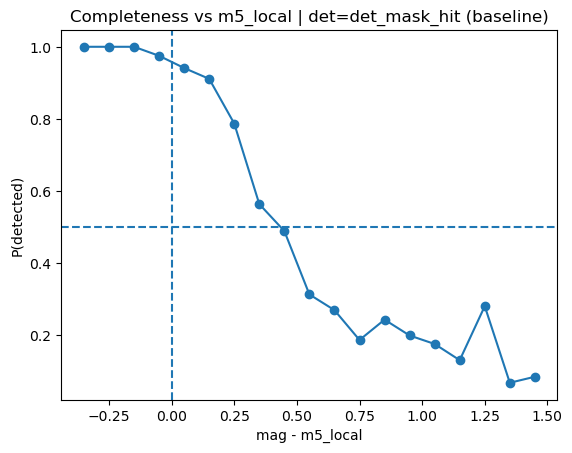

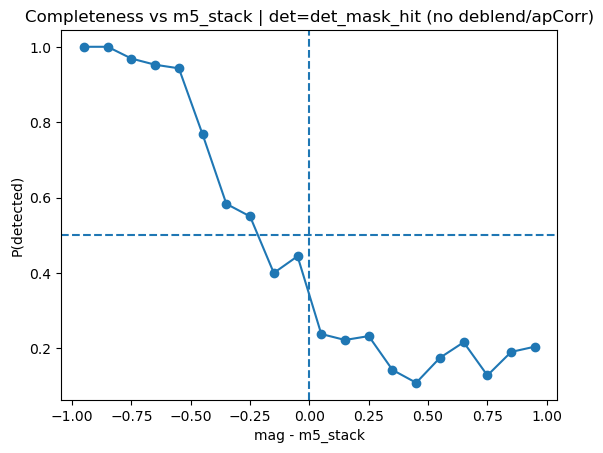

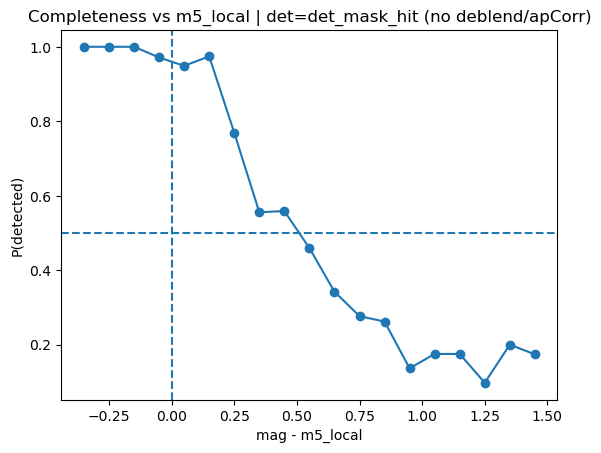

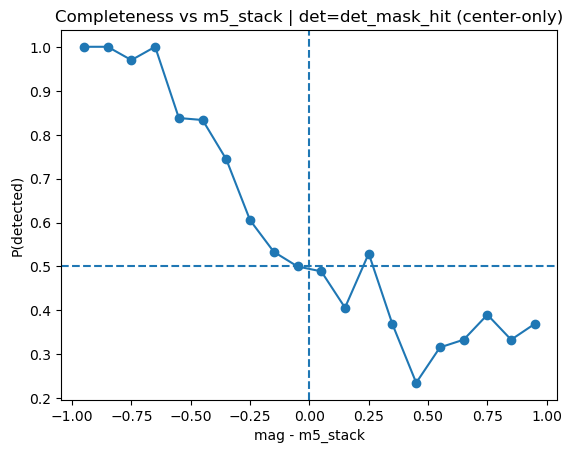

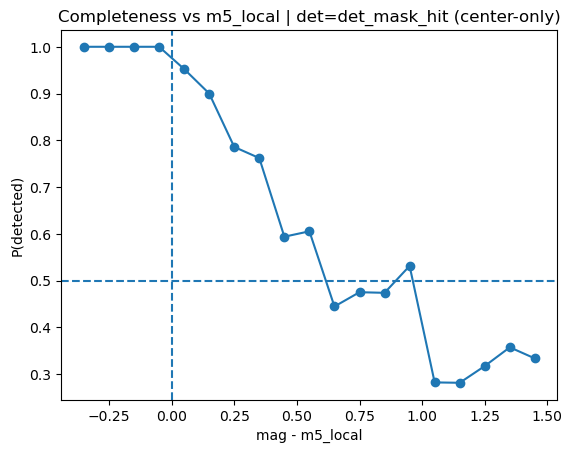

In [17]:
print("=== Baseline ===")
summarize_detection(inj, "baseline")
print("=== NoDeblend ===")
summarize_detection(inj_nodb, "no deblend/apCorr")
print("=== Center-only ===")
summarize_detection(inj_center, "center-only")

# Main question: does DETECTED-based completeness line up better with m5_stack?
plot_completeness_vs_m5(inj, det_col="det_mask_hit", title_suffix="(baseline)")
plot_completeness_vs_m5(inj_nodb, det_col="det_mask_hit", title_suffix="(no deblend/apCorr)")
plot_completeness_vs_m5(inj_center, det_col="det_mask_hit", title_suffix="(center-only)")


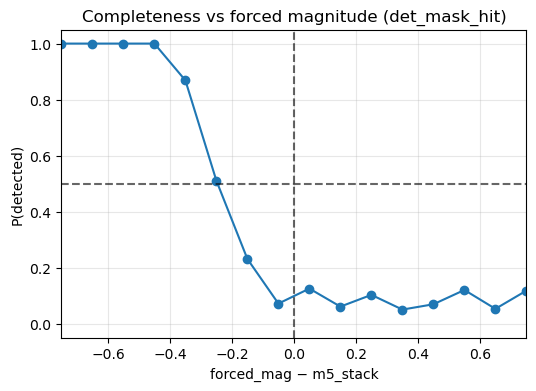

50% crossing not found in range.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Choose detection definition
# ----------------------------
# det_col = "posmatch_0p6"     # catalog-based detection
det_col = "det_mask_hit"       # DETECTED-plane detection

# ----------------------------
# Choose m5 reference
# ----------------------------
# m5_col = "m5_local"
m5_col = "m5_stack"

# ----------------------------
# Build forced-magnitude axis
# ----------------------------
df = inj.copy()

# Use only rows with a defined forced magnitude
sel = np.isfinite(df["forced_diff_mag"].values) & np.isfinite(df[m5_col].values)
df = df.loc[sel].copy()

x = df["forced_diff_mag"].values - df[m5_col].values
detected = df[det_col].astype(bool).values

# ----------------------------
# Bin & compute completeness
# ----------------------------
bins = np.arange(-2.0, 2.01, 0.1)

rows = []
for lo, hi in zip(bins[:-1], bins[1:]):
    m = (x >= lo) & (x < hi)
    n = int(m.sum())
    if n == 0:
        continue
    rows.append({
        "xmid": 0.5*(lo+hi),
        "n": n,
        "p_det": float(np.mean(detected[m]))
    })

comp = pd.DataFrame(rows)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(6,4))
plt.plot(comp["xmid"], comp["p_det"], marker="o", lw=1.5)
plt.axvline(0.0, ls="--", c="k", alpha=0.6)
plt.axhline(0.5, ls="--", c="k", alpha=0.6)
plt.xlabel(f"forced_mag − {m5_col}")
plt.ylabel("P(detected)")
plt.title(f"Completeness vs forced magnitude ({det_col})")
plt.ylim(-0.05, 1.05)
plt.xlim(-0.75, 0.75)
plt.grid(alpha=0.3)
plt.show()

# ----------------------------
# Report 50% point (linear interp)
# ----------------------------
if len(comp) > 2:
    # find where curve crosses 0.5
    y = comp["p_det"].values
    xm = comp["xmid"].values
    idx = np.where((y[:-1] < 0.5) & (y[1:] >= 0.5))[0]
    if len(idx):
        i = idx[0]
        # linear interpolation
        x50 = xm[i] + (0.5 - y[i]) * (xm[i+1] - xm[i]) / (y[i+1] - y[i])
        print(f"~50% completeness at forced_mag − {m5_col} ≈ {x50:.3f} mag")
    else:
        print("50% crossing not found in range.")
